# XAI Praca domowa 6
Mikołaj Pacek
## 'Fairness' titanica
Do tego zadania użyłem zbioru o ofiarach katastrofy titanica. Kolumna wg, które będziemy badać fairness to płeć.

In [122]:
import pandas as pd
import matplotlib.pyplot as plt

df_train = pd.read_csv("train.csv").drop(columns=["PassengerId"])
df_train = df_train.drop(columns=["Name", "Cabin", "Ticket"])
df_train = df_train.dropna()
df_train = pd.get_dummies(df_train)

def split(df_train):
    return df_train.drop(columns=["Survived"]), df_train["Survived"] == 1

x_train, y_train = split(df_train)

In [146]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

# Modele
Celem jest modelu jest klasyfikacja czy pasażer przeżył. Wybrałem 4 modele klasyfikujące:
- RandomForestClassifier
- GradientBoostingClassifier
- LogisticRegression
- KNeighborsClassifier

Do tego będziemy patrzeć na 3 metryki fairness:
- statisical_parity
- equal_opportunity
- predictive_equality

In [ ]:
import numpy as np
import copy
from tqdm import tqdm
import itertools

def get_fairness_stats(model, x, y):
    tn, fp, fn, tp = confusion_matrix(model.predict(x), y).ravel()
    return {
        "statisical_parity": (tp + fp) / sum([tn, fp, fn, tp]),
        "equal_opportunity": tp / (tp + fn),
        "predictive_equality": fp / (fp + tn),
    }

models = {
    "random forest": RandomForestClassifier, 
    "logistic": LogisticRegression, 
    "gradient boost": GradientBoostingClassifier,
    'KNN': KNeighborsClassifier,
}

model_to_stats = {}
for model_name, model_cls in models.items():
    model = model_cls()
    model.fit(x_train, y_train)

    df_male = df_train[df_train["Sex_male"] == 1]
    df_female = df_train[df_train["Sex_female"] == 1]
    
    male_stats = get_fairness_stats(model, *split(df_male))
    female_stats = get_fairness_stats(model, *split(df_female))
    
    model_to_stats[model_name] = {"male": male_stats, "female": female_stats}

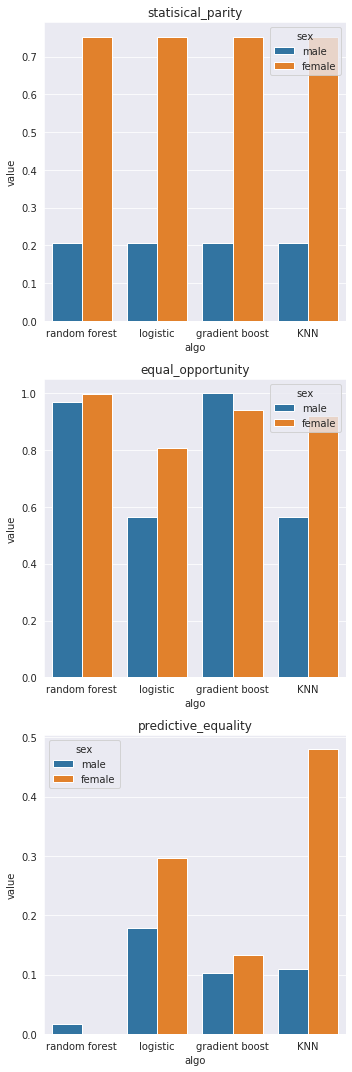

In [156]:
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt

df = pd.DataFrame()
for algo, stats in model_to_stats.items():
    for sex, metric_to_value in stats.items():
        for metric, value in metric_to_value.items():
            df = df.append({
                "algo": algo,
                "metric": metric,
                "sex": sex,
                "value": value
            }, ignore_index=True)
            
fig, ax = plt.subplots(3, 1, figsize=(5, 15))
for i, metric in enumerate(df["metric"].unique()):
    sns.barplot(data=df[df["metric"].eq(metric)], x="algo", y="value", hue="sex", ax=ax[i])
    ax[i].set_title(metric)
fig.tight_layout()

# Wnioski
- wytrenowane model 'dyskryminują' mężczyzn (prawie zawsze metryka jest większa dla kobiet)
- tylko metryka equal_opportunity wydaje się być satysfakcjonowana pod względem fairness
- bias w kierunku mężczyzn może wynikać z tego, że więcej kobiet przetrwało katastrofę